<a href="https://colab.research.google.com/github/alexunderch/Bachelor_materials/blob/main/Lab2_DL_part3_poetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616
maxlen_ = len(max(text, key = len))
print("Max seq contains {} symbols".format(maxlen_))

--2020-12-13 10:25:25--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.007s  

2020-12-13 10:25:25 (15.5 MB/s) - ‘sonnets.txt’ saved [119748/119748]

Max seq contains 63 symbols


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
text = "".join([x.lower() for x in text])

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [ ]:
if not os.path.exists('onegin.txt'):
    !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    o_text = iofile.readlines()
    
o_text = [x.replace('\t\t', '') for x in o_text]
maxlen = len(max(o_text, key = len))
print("Max seq contains {} symbols".format(maxlen))

--2020-12-08 15:41:36--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2020-12-08 15:41:36 (13.1 MB/s) - ‘onegin.txt’ saved [262521/262521]

Max seq contains 159 symbols


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
def prepare_data(text):
    text = "".join([x.lower() for x in text])
    print("The lenght of given tokens  = {}".format(len(text)))

    tokens = sorted(set(text))
    print("Number of given tokens  = {}".format(len(tokens)))

    return tokens, text
tokens, text = prepare_data(text)

The lenght of given tokens  = 100225
Number of given tokens  = 38



Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [ ]:
batch_size = 512

# def one_hot_encode(sequence, dict_size = len(tokens_sh)):
#     seq_len = len(sequence)
#     features = np.zeros((seq_len, dict_size), dtype = np.int64)
#     features[np.arange(seq_len), [token_to_idx[s] for s in sequence]] = 1

#     return features

def create_mapping(tokens):
    """
    INPUT: tokens -- sorted set of tokens
    OUTPUT: 
    token_to_idx: dict <index>:<char>
    idx_to_token:dict <char>:<index>
    """
    token_to_idx = {token: idx for idx, token in enumerate(tokens)}
    idx_to_token = dict(enumerate(tokens))
    return token_to_idx, idx_to_token


token_to_idx, idx_to_token = create_mapping(tokens)

def prepare_set(text, tokens, maxlen, step = 1):
    token_to_idx, idx_to_token = create_mapping(tokens)
    sentences, next_tokens = [], []
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i : i + maxlen])
        next_tokens.append(text[i + maxlen])

    print("Number of sequences:", len(sentences))
    x = np.zeros((len(sentences), maxlen, len(tokens)))
    y = np.zeros((len(sentences), len(tokens)))
    for i, sentence in enumerate(sentences):
        for t, token in enumerate(sentence):
            x[i, t, token_to_idx[token]] = 1
        y[i, token_to_idx[next_tokens[i]]] = 1  
    return x, y

In [ ]:
x, y = prepare_set(text, tokens, maxlen = 64)
print(x.shape)

Number of sequences: 100161
(100161, 64, 38)


### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
# Your code here  
class VanillaRNN(nn.Module):
    def __init__(self, n_tokens = len(tokens), hidden_dim = 128, emb_dim = 128,
                 n_layers = 1):
        super(VanillaRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_tokens = n_tokens
        
        self.embed = nn.Embedding(n_tokens, self.emb_dim)
        self.rnn = nn.RNN(self.emb_dim, self.hidden_dim, batch_first =  True)
        self.dropout  = nn.Dropout(.35)
        self.hid_to_logits = nn.Linear(self.hidden_dim, n_tokens)
    
    def forward(self, x, h_prev):
        h_seq, h = self.rnn(self.embed(x), h_prev)
        h_seq = self.dropout(h_seq)
        next_logits = self.hid_to_logits(h_seq)
        return next_logits, h
    
    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

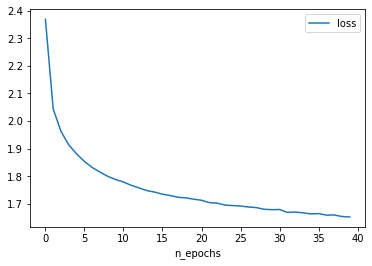

Loss after the epoch # 41 1.64920705587436
Loss after the epoch # 42 1.651544366738735
Loss after the epoch # 43 1.6476189576662503
Loss after the epoch # 44 1.6469092069528042
Loss after the epoch # 45 1.6454708918547019


In [ ]:
# Your plot code here
model_rnn = VanillaRNN()
opt = torch.optim.Adam(model_rnn.parameters())
model_rnn.to(device)
criterion = nn.CrossEntropyLoss()

n_epochs = 45
history = []
_ = model_rnn.train()

for epoch in range(n_epochs):
    ep_history = []
    hidden_state = model_rnn.initial_state(batch_size)
    for batch_ind in range(batch_size, x.shape[0], batch_size):
        
        opt.zero_grad()
        x_batch = torch.argmax(torch.Tensor(x[batch_ind - batch_size : batch_ind]), dim = -1).to(device)
        y_batch = torch.argmax(torch.Tensor(y[batch_ind - batch_size : batch_ind]), dim = -1).to(device)

        opt.zero_grad()
    
        seq, hidden_state = model_rnn(x_batch, hidden_state)
        loss = criterion(seq[:, -1].contiguous(), y_batch.contiguous())  
        
        loss.backward()
        opt.step()  
        ep_history.append(loss.item())
        hidden_state = hidden_state.detach()

    history.append(np.mean(ep_history))
    print("Loss after the epoch # {}".format(epoch + 1), history[-1])
    if (epoch + 1) % 10 == 0:
        clear_output(True)
        plt.plot(history, label = 'loss')
        plt.xlabel("n_epochs")
        plt.legend()
        plt.show()

In [ ]:
# _ = save_net(model_rnn, "O_RNN.net", opt)

In [ ]:
def generate_text(char_rnn, tokens = tokens, seed_phrase = 'fucking society! ', 
                    max_length = 100, temperature = 1., flag = False):
  
    def sample(preds, tokens, temperature = 1.):
        preds =  F.softmax(preds / temperature, dim = -1).cpu().data.numpy().squeeze()
        # print(preds.shape)
        next_ix = np.random.choice(len(tokens), p = preds)
        return torch.LongTensor([[next_ix]])

    x_sequence = torch.Tensor([np.array([token_to_idx[token] for token in seed_phrase.lower()])]).to(device)
    hid_state = char_rnn.initial_state(batch_size = 1)

    if flag: hid_state = tuple([each.data for each in hid_state])

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(torch.stack([x_sequence[:, i].long()]), hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(torch.stack([x_sequence[:, -1].long()]), hid_state)
        next_ix = sample(out, tokens, temperature)

        x_sequence = torch.cat([x_sequence, next_ix.to(device)], dim = 1)
    return ''.join([tokens[int(ix)] for ix in x_sequence.cpu().data.numpy()[0]])

In [ ]:
# An example of generated text.
# checkpoint = torch.load("ShRNN.net")
# model_rnn.load_state_dict(checkpoint['state_dict'])
# opt.load_state_dict(checkpoint['opt_state_dict'])
_ = model_rnn.eval()
print(generate_text(char_rnn = model_rnn,  max_length = 500, temperature = 1.))

fucking society! where with shave thy sake thy self dietty pully is suibl'ds for me
  te for-prim,
  dome!
  i my houts to thel, in mants libjens, art mine to dead lhal hid heast thy distrong doth forweati fift owol ckastisgrw,
  make proos'd,
  tair beaver, if being byes that rele;
    and mming winking they yulitenthe that my conbliok thou betul, or froms,
  mine her cheatifanftion ccewilad is nefites eacy lye pard'ming, swill'd,
  thas thine shom thy's wiends, and love is my sol'd,
  that my 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

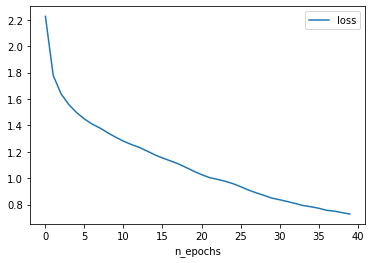

In [ ]:
# Your beautiful code here
class LSTM (nn.Module):
    def __init__(self, n_tokens = len(tokens), hidden_dim = 256, emb_dim = 128,
                 n_layers = 1):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_tokens = emb_dim
        
        self.embed = nn.Embedding(n_tokens, self.emb_dim)
        self.lstm = nn.LSTM(self.emb_dim, self.hidden_dim, batch_first =  True)
        self.hid_to_logits = nn.Linear(self.hidden_dim, n_tokens)
    
    def forward(self, x, hidden_state):
        out, hidden_state = self.lstm(self.embed(x), hidden_state)
        out = self.hid_to_logits(out)
      
        return out, hidden_state
    
    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

model_lstm = LSTM()
opt = torch.optim.Adam(model_lstm.parameters())
model_lstm.to(device)
criterion = nn.CrossEntropyLoss()

n_epochs = 40
history = []
_ = model_lstm.train()
for epoch in range(n_epochs):
    ep_history = []
    hidden_state = model_lstm.initial_state(batch_size)
    for batch_ind in range(batch_size, x.shape[0], batch_size):
        
        x_batch = torch.argmax(torch.Tensor(x[batch_ind - batch_size : batch_ind]), dim = -1).to(device)
        y_batch = torch.argmax(torch.Tensor(y[batch_ind - batch_size : batch_ind]), dim = -1).to(device)

        hidden_state = tuple([each.data for each in hidden_state])

        opt.zero_grad()
    
        seq, hidden_state = model_lstm(x_batch, hidden_state)
        loss = criterion(seq[:, -1].contiguous(), y_batch.contiguous())  
        loss.backward()
        opt.step()  
        ep_history.append(loss.item())
    history.append(np.mean(ep_history))
    print("Loss after the epoch # {}".format(epoch + 1), history[-1])

    if (epoch + 1) % 5 == 0:
        clear_output(True)
        plt.plot(history, label = 'loss')
        plt.xlabel("n_epochs")
        plt.legend()
        plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# _= save_net(model_lstm, "O_LSTM.net", opt)

In [ ]:
# Text generation with different temperature values here 
# checkpoint = torch.load("ShLSTM.net")
# model_lstm.load_state_dict(checkpoint['state_dict'])
# opt.load_state_dict(checkpoint['opt_state_dict'])

_ = model_lstm.eval()

# def entropy(labels, base = None):
#   values, counts = np.unique(labels, return_counts = True)
#   norm_counts = counts / counts.sum()
#   base = np.exp(1.) if base is None else base
#   return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
  print("TEMPERATURE = ", temperature)
  poetry = generate_text(char_rnn = model_lstm, temperature = temperature,
                      max_length = 400, seed_phrase = "Listen, Bitch! ")
  # print("Shannon entropy of given phrase = ", round(entropy(poetry), 3), '\n')

  print('\t', poetry, '\n')

TEMPERATURE =  0.1
	 listen, bitch! kind,
  on the sun is death, which thou art be so, tongue:
  nor dead that feast, who let me not from me.

  cxxxviii

  what no man respore more base that from hend:
  then thou thy self thou shouldst still,
  one mine own love, thou mayst to me another delight.
  i will in my self, all thy self desert,
  and in the present me with thee to be replent,
  which put for my sinful eart 

TEMPERATURE =  0.2
	 listen, bitch! kind,
  on the sun is double not thy side.
    if thou thy self to his store;
  doth spures is my love swears than love thee face,
  for not do not so me that leaves me,
  the world will be the counter take:
  make me gones, and they do before,
  the outward of thy self away,
  deserve thou wilt not be feel in my sight,
  deserve to proud hath possess she things to see;
  for it dos 

TEMPERATURE =  0.5
	 listen, bitch! kind;
  and sittent touble and my poor praise.

  cxliv

  if it believe me thou lov'st else of thee,
  which should

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here
def save_net(net, name: str, opt):
    checkpoint = {'state_dict': net.state_dict(),
                  'opt_state_dict': opt.state_dict()}

    with open(name, 'wb') as f:
        torch.save(checkpoint, f)

_= save_net(model_lstm, "Sh_LSTM.net", opt)
checkpoint = torch.load("Sh_LSTM.net")
model_lstm.load_state_dict(checkpoint['state_dict'])
opt.load_state_dict(checkpoint['opt_state_dict'])
_ = model_lstm.eval()
print(generate_text(char_rnn = model_lstm, temperature = 1.,
                      max_length = 450, seed_phrase = "Listen, You! "))

listen, you! but from thee,
  who let frees i that filch'd in parte;
  who triue things i think on this poor restire!
  o man, nor takes of part; my favourity
  without criefor lives despite thy pring,
  and keep placious that is poor me me blet;
  although bounteous shalt nothing still to let,
    and me to triumph's sublied what this sober'd,
  which better in that you may their valy;
  are not this in deserts add thee,
  and did unfenths for f


Загрузка моделей для генерации текста закомментирована в начале каждого `generate_text`. Видно, что с ростом температуры случайность сгенерированного текста сильно увеличивиается.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)